In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/research/xaqlab/ergm.jl`


In [7]:
using ergm.sampler
using ergm.spaces
using ergm.stats
using ergm.models
using ergm.inference
using ergm.optim
using LinearAlgebra
using Random

n = 30
ps = randn((n, 3))
D = [norm(ps[i, :] - ps[j, :]) for i ∈ 1:n, j ∈ 1:n]
f(d) = exp(d)
stats = DeltaStats(
    function(G)
        p = sum(G.adjacency) / (n * (n - 1))
        [
            p,
            -sum(G.adjacency .* f.(D)) / (n * (n - 1)),
            tr(G.adjacency ^ 3) / (n * (n - 1) * (n - 2)) - p ^ 3
        ]
    end,
    function(G, s, u)
        i, x = u
        p = s[1]
        dp = (x - G[i]) / (n * (n - 1))
        s + [
            (x - G[i]) / (n * (n - 1)),
            -(x - G[i]) * f(D[i[1], i[2]]) / (n * (n - 1)),
            3 * (x - G[i]) * dot(G.adjacency[i[2], :], G.adjacency[:, i[1]]) / (n * (n - 1) * (n - 2)) - (p + dp) ^ 3 + p ^ 3
        ]
    end
)
θ0 = [-1e3, 1e3, 1e6]
m = ExponentialFamily(stats, θ0)
G0 = DiGraph(zeros(Bool, (n, n)))
samp = ParallelGibbsSampler(
    G0,
    m,
    10,
    10,
    Threads.nthreads()
)
Gs, ss = sample(samp, 100)

(Any[DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0)  …  DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0), DiGraph(Bool

In [8]:
n_bins = 40
bin_width = maximum(D) / (n_bins - 1)
bins_n = zeros(n_bins)
bins_y = zeros(n_bins)

for G ∈ Gs
    for (d, e) ∈ zip(D, G.adjacency)
        b = trunc(Int64, d ÷ bin_width) + 1

        if 1 ≤ b ≤ n_bins
            bins_n[b] += 1

            if e
                bins_y[b] += 1
            end
        else
            println(b)
            break
        end
    end
end

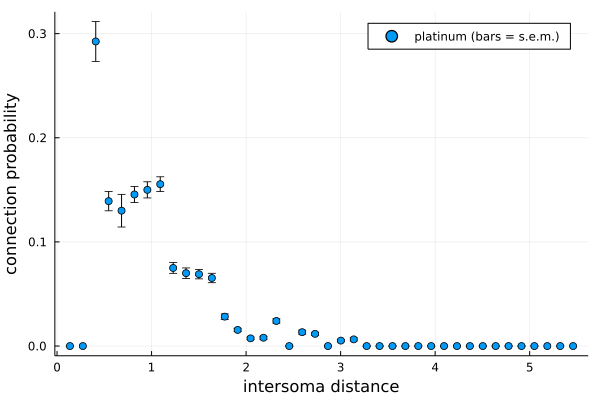

In [9]:
using Plots

ps = replace(bins_y ./ bins_n, NaN => 0.0)
ds_p = bin_width * (1:n_bins)
sems = [sqrt(ps[i] * (1 - ps[i]) ^ 2) / sqrt(bins_n[i]) for i ∈ 1:n_bins]
scatter(ds_p, ps, label="platinum (bars = s.e.m.)", yerr=sems, xlabel="intersoma distance", ylabel="connection probability")

# Attempt at Fitting

In [11]:
using ergm.platinum

G = load_graph()

PyObject <networkx.classes.multidigraph.MultiDiGraph object at 0x7f2a6c1ebbb0>

In [ ]:
Hs_nx = subsample(G, n, 1000)
Hs = map(

In [6]:
target_Es = [0.3, 0.035]
θ01 = log(target_Es[1] / (1 - target_Es[1])) * n * (n - 1)
θ0 = [θ01, 0.0, 0.0]
m = ExponentialFamily(stats, θ0)
G0 = DiGraph(convert(Matrix{Bool}, rand(Float64, (n, n)) .< target_Es[1]))
o = ADAM(1000.0, 0.7, 0.9, 1e-8, θ0, 50, 0.0, "../logs/a.txt")
θs, Ls, target_Es, Es = mcmc_mle_from_stats(target_Es, [G0], m, o, 1000, 10, 3)

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 3 and 2")

In [ ]:
θ